# CS/ECE/ISyE 524 - Spr 2018 - HW 1 - Solutions
### Prepared by: Laurent Lessard

---
## 1. Warm up
Model the following problem in JuMP. 

$$\begin{aligned}
\text{maximize}\qquad& 5x_1 − x_2 + 11x_3\\
\text{subject to:}\qquad& 2x_1 \ge x_2 + x_3 \\
& 0 \le x_j \le 3, \ \ j=1,...,3
\end{aligned}$$

Solve this problem using Clp, ECOS, and SCS. Compare the answers found by each solver.

In [6]:
using JuMP

# function that solves the LP k times using the specified solver
function solveLP(solver,k)
    m = Model(solver=solver)
    @variable(m, 0 <= x[1:3] <= 3)
    @constraint(m, 2x[1] >= x[2] + x[3] )
    @objective(m, Max, 5x[1] - x[2] + 11x[3] )
    status = ""
    for i = 1:k
        status = solve(m)
    end
    println()
    println("SOLVER: ", m.solver)
    println("STATUS: ", status)
    println("x = ", getvalue(x))
    println("objective = ", getobjectivevalue(m) )
end;

In [8]:
using Clp, ECOS, SCS
for solver in [ ClpSolver(), ECOSSolver(verbose=0), SCSSolver(verbose=0) ]
    @time solveLP(solver,100)
end


SOLVER: Clp.ClpMathProgSolverInterface.ClpSolver(Any[])
STATUS: Optimal
x = [3.0, 0.0, 3.0]
objective = 48.0
  0.010426 seconds (4.14 k allocations: 267.828 KiB)

SOLVER: ECOS.ECOSSolver(Any[(:verbose, 0)])
STATUS: Optimal
x = [3.0, 8.22327e-9, 3.0]
objective = 47.999999986810174
  0.021148 seconds (50.09 k allocations: 2.862 MiB)

SOLVER: SCS.SCSSolver(Any[(:verbose, 0)])
STATUS: Optimal
x = [2.99999, 4.14972e-6, 3.00001]
objective = 48.00006780505256
  0.042453 seconds (41.01 k allocations: 2.368 MiB)


**Comments:** the most accurate solver is Clp, because it is a dedicated LP solver. The other two solvers are less accurate (and slower) because they are using more general algorithms that are less specialized and more boradly applicable.

---
## 2. Crop planning

Farmer Jane owns 45 acres of land. She is going to plant each with wheat or corn. Each acre planted with wheat yields \$200 profit; each with corn yields \$300 profit. The labor and fertilizer used for each acre are given in the table below. One hundred workers and 120 tons of fertilizer are available. How should Jane plant her crops to maximize profits from her land?

|            | Wheat     | Corn      |
|:-----------|:----------|:----------|
| Labor      | 3 workers | 2 workers |
| Fertilizer | 2 tons    | 4 tons    |

In [9]:
using JuMP, Clp

m = Model(solver = ClpSolver())

@variable(m, wheat >= 0)                   # acres of wheat planted, must be nonnegative
@variable(m, corn  >= 0)                   # acres of corn planted, must be nonnegative
@constraint(m, wheat + corn <= 45 )        # acreage budget
@constraint(m, 3*wheat + 2*corn <= 100 )   # labor budget
@constraint(m, 2*wheat + 4*corn <= 120 )   # fertilizer budget
@objective(m, Max, 200*wheat + 300*corn )  # maximize profit

solve(m)
println("acres of wheat planted: ", getvalue(wheat))
println("acres of corn planted:  ", getvalue(corn))
println("total profit: \$", getobjectivevalue(m))

acres of wheat planted: 19.99999999999999
acres of corn planted:  20.000000000000007
total profit: $10000.0


**Comments:** Jane should plant 20 acres of wheat and 20 acres of corn. Although the solution returned by Clp isn't *exactly* 20, this is simply due to numerical round-off error. As we see in the geometrical approach, the solution is actually exactly (20,20). Here is a version of the code where the parameters are separated from the solution.

In [11]:
using JuMP, Clp

# problem parameters

acre_budget = 45         # total acres available for wheat and corn

labor_budget = 100       # total hours of labor available
labor_per_wheat = 3      # hours of labor per acre of wheat
labor_per_corn = 2       # hours of labor per acre of corn

fert_budget = 120        # total tons of fertilizer available
fert_per_wheat = 2       # tons of fertilizer required per acre of wheat
fert_per_corn = 4        # tons of fertilizer required per acre of corn

profit_of_wheat = 200    # profit earned for planting one acre of wheat, in dollars
profit_of_corn = 300     # profit earned for planting one acre of corn, in dollars


# create model and declare variables

m = Model(solver = ClpSolver())
@variable(m, wheat >= 0)                   # acres of wheat planted, must be nonnegative
@variable(m, corn  >= 0)                   # acres of corn planted, must be nonnegative

# declare some useful expressions
@expression(m, acres_used, wheat + corn)                                  # total acres used
@expression(m, fert_used, fert_per_wheat*wheat + fert_per_corn*corn)      # total fertilizer used
@expression(m, labor_used, labor_per_wheat*wheat + labor_per_corn*corn)   # total labor used
@expression(m, total_profit, profit_of_wheat*wheat + profit_of_corn*corn) # total profit in dollars

# problem constraints and objective
@constraint(m, acres_used <= acre_budget )    # don't exceed acreage budget
@constraint(m, fert_used <= fert_budget )     # don't exceed fertilizer budget
@constraint(m, labor_used <= labor_budget )   # don't exceed labor budget
@objective(m, Max, total_profit )             # maximize profit

solve(m)
println("acres of wheat planted: ", getvalue(wheat))
println("acres of corn planted:  ", getvalue(corn))
println("total profit: \$", getvalue(total_profit))

acres of wheat planted: 19.99999999999999
acres of corn planted:  20.000000000000007
total profit: $10000.0


**Comments:** We did not expect a solution this detailed; just showing an example of how detailed things can get! 

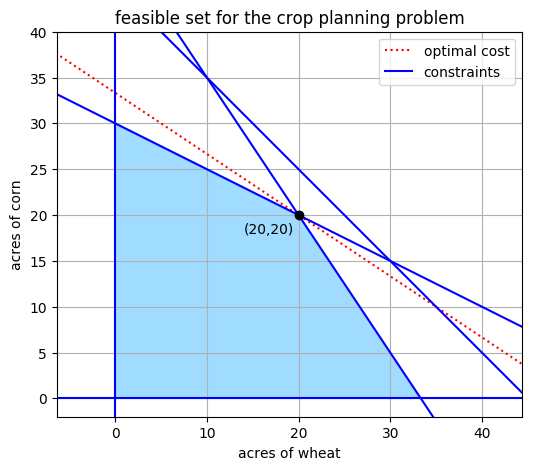

In [14]:
# here is PyPlot code that plots the region and shows the optimal value
using PyPlot
figure(figsize=(6,5))

# express each constraint as corn = f(wheat)
w = linspace(-10,80,3)
plot( w, (10000-200*w)/300, "r:")      # cost (200w + 300c = 10000)
plot( w, 0*w, "b-" )                   # c = 0
plot( 0*w, w, "b-" )                   # w = 0
plot( w, (100 - 3*w)/2, "b-")          # 3w + 2c = 100
plot( w, (120 - 2*w)/4, "b-")          # 2w + 4c = 120
plot( w, 45-w, "b-")                   # w + c = 45
plot( 20, 20, "k.", markersize=12)     # optimal point (20,20)
text( 14, 18, "(20,20)")
fill( [0, 0, 20, 100/3, 0], [0, 30, 20, 0, 0], color=(160/255,220/255,255/255) )
grid(); axis("equal"); axis([-2,40,-2,40]); 
xlabel("acres of wheat");  ylabel("acres of corn")
legend(["optimal cost", "constraints"])
title("feasible set for the crop planning problem");